In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})

X = data.drop(columns={"diagnosis"})
y = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
X = X.drop(columns={"id"})
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:


kf = KFold(n_splits=5, shuffle=True, random_state=42)
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances[f'Fold_{fold+1}'] = importances

# Average importances
feature_importances['Mean'] = feature_importances.mean(axis=1)
top_features = feature_importances['Mean'].nlargest(10).index


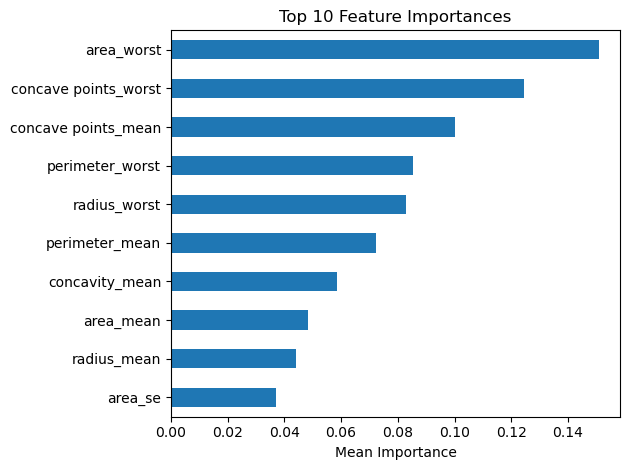

In [4]:
import matplotlib.pyplot as plt

feature_importances.loc[top_features, 'Mean'].sort_values().plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

X_top = X[top_features]
scaler = StandardScaler()
X_top_scaled = pd.DataFrame(scaler.fit_transform(X_top), columns=top_features)

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_top_scaled, y)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)


Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


Train Accuracy: 1.0000
Test Accuracy: 0.9474


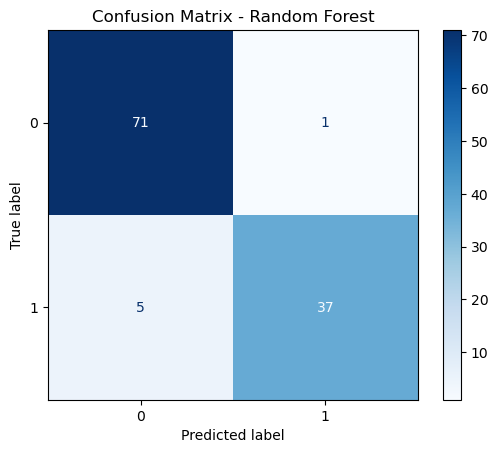

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use only your selected top features
X_final = X[top_features]  # X: full original feature DataFrame
y_final = y                # target labels

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train with tuned hyperparameters
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion matrix on test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()
